In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import os

In [3]:
img_dir='./cell_images/'

In [8]:
path=Path(img_dir)

In [9]:
data = ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [10]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['infected', 'uninfected']


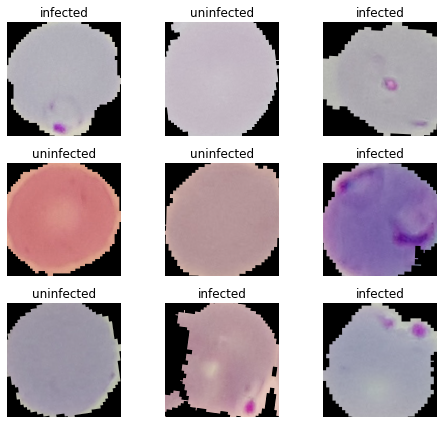

In [11]:
data.show_batch(rows=3, figsize=(7,6))

In [15]:
learn = create_cnn(data, models.resnet34, metrics=accuracy, model_dir="/tmp/model/")

/home/harsha/anaconda3/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/harsha/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:21<00:00, 4.13MB/s]


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


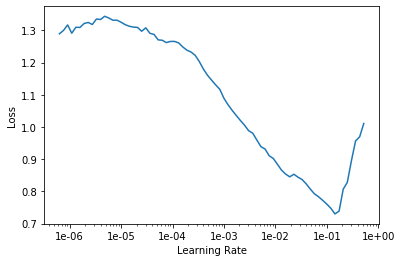

In [16]:
learn.lr_find()
learn.recorder.plot()

In [17]:
learn.fit_one_cycle(6,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.257187,0.144297,0.958104,11:07
1,0.198808,0.236427,0.921703,13:30
2,0.161040,0.161945,0.956731,11:30
3,0.119107,0.112761,0.958104,11:09
4,0.098380,0.067213,0.971841,10:32
5,0.079937,0.069176,0.968407,10:09


In [18]:
learn.save('stage-1')

In [19]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


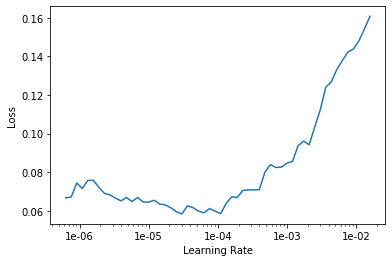

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(2, max_lr=slice(5e-6,5e-5 ))

epoch,train_loss,valid_loss,accuracy,time
0,0.075466,0.070346,0.969093,14:07
1,0.070007,0.067150,0.971841,15:43


In [22]:
learn.save('stage-2')

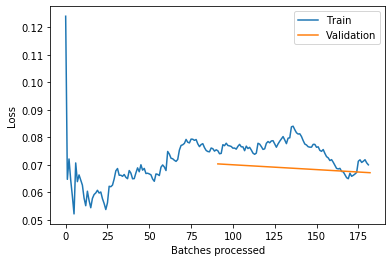

In [23]:
learn.recorder.plot_losses()

In [24]:
interp = ClassificationInterpretation.from_learner(learn)

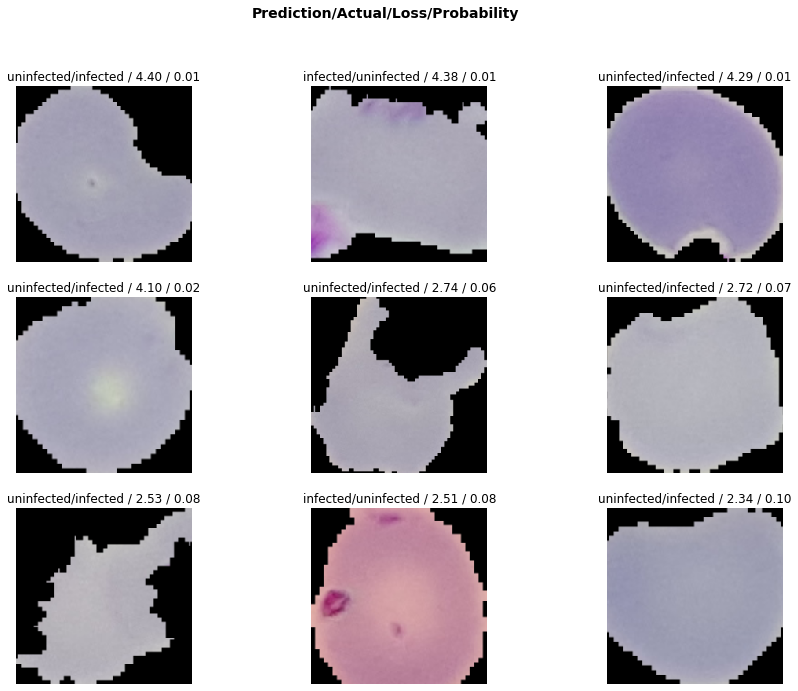

In [25]:
interp.plot_top_losses(9, figsize=(15,11))

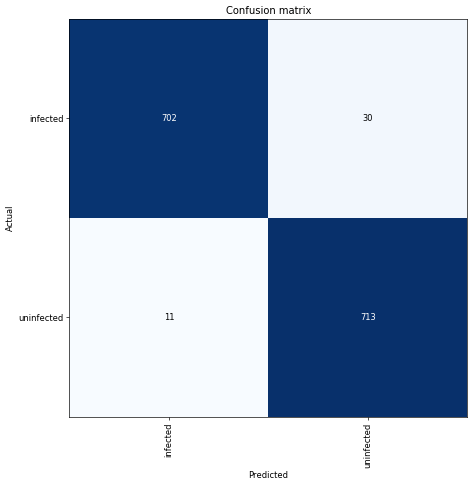

In [26]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [27]:
interp.most_confused(min_val=2)

[('infected', 'uninfected', 30), ('uninfected', 'infected', 11)]

In [28]:
pred_data= ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [29]:
predictor=create_cnn(data, models.resnet34, metrics=accuracy, model_dir="/tmp/model/").load('stage-2')

/home/harsha/anaconda3/lib/python3.7/site-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [30]:
pred_data.single_from_classes(path, pred_data.classes)

ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: cell_images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: cell_images;

Test: None

Category infected

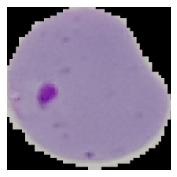

In [31]:
x,y = data.valid_ds[3]
x.show()
data.valid_ds.y[3]

fastai.vision.image.Image

In [34]:
pred_class,pred_idx,outputs = predictor.predict(x)
pred_class

Category infected

In [38]:
pred_class

Category infected

In [ ]:
def heatMap(x,y,data, learner, size=(0,224,224,0)):
    """HeatMap"""
    
    # Evaluation mode
    m=learner.model.eval()
    
    # Denormalize the image
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    # hook the activations
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(y)].backward()

    # Activations    
    acts=hook_a.stored[0].cpu()
    
    # Avg of the activations
    avg_acts=acts.mean(0)
    
    # Show HeatMap
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.5, extent=size,
              interpolation='bilinear', cmap='magma')

In [ ]:
heatMap(x,y,pred_data,learn)